# 2. 线性量化

顾名思义，线性量化是将原始浮点数据和量化后的定点数据之间建立一个简单的线性变换关系，因为卷积、全连接等网络层本身只是简单的线性计算，因此线性量化中可以直接用量化后的数据进行直接计算。

浮点和整型之间的换算公式为：
$$r = (q - Z) / scale$$ 
$$q = round(r / S + Z)$$ 

&emsp;&emsp;其中，S 是scale，表示实数和整数之间的比例关系，Z 是 zero point，表示浮点数中的 0 经过量化后对应的整数，它们的计算方法为：
$$S =  \frac{r_{max} - r_{min}}{q_{max} - q_{min}}$$ 
$$Z = round(q_{max}-\frac{r_{max}}{S})$$ 

&emsp;&emsp;其中，$r_{max}$ 和 $r_{max}$分别表示浮点数中的最小值和最大值,$q_{max}$ 和 $q_{min}$分别表示定点数中的最小值和最大值。

![线性量化](../../ch04/images/线性量化.jpg)

## 2.1 环境配置

首先，我们安装必须的环境，数据集和model使用和前几章相同的minist数据集和LeNet网络。（PS：最好先创建一个单独的conda环境）

In [201]:
print('Installing torchprofile...')
# !pip install torchprofile -i https://pypi.tuna.tsinghua.edu.cn/simple/
print('Installing fast-pytorch-kmeans...')
# ! pip install fast-pytorch-kmeans -i https://pypi.tuna.tsinghua.edu.cn/simple/
# ! pip install matplotlib -i https://pypi.tuna.tsinghua.edu.cn/simple/
# ! pip install tqdm -i https://pypi.tuna.tsinghua.edu.cn/simple/
# ! conda install pytorch::pytorch torchvision torchaudio -c pytorch 
# pytorch的安装最好去官网找适合自己的版本命令安装
print('All required packages have been successfully installed!')

Installing torchprofile...
Installing fast-pytorch-kmeans...
All required packages have been successfully installed!


In [202]:
import copy
import math
import random
from collections import OrderedDict, defaultdict

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
from tqdm.auto import tqdm

import torch
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchprofile import profile_macs
from torchvision.datasets import *
from torchvision.transforms import *
import torch.nn.functional as F
from torchvision import datasets
from utils import LeNet,train,evaluate,get_model_size,get_model_flops,MiB

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

## 2.2 构建模型和数据集

In [203]:
class LeNet(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.relu1 = nn.ReLU()
    
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.relu2 = nn.ReLU()
        
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(in_features=16 * 4 * 4, out_features=120)
        self.relu3 = nn.ReLU()
        
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.relu4 = nn.ReLU()
        
        self.fc3 = nn.Linear(in_features=84, out_features=num_classes)
       
    def forward(self, x):
        x = self.maxpool1(self.relu1(self.conv1(x)))
        x = self.maxpool2(self.relu2(self.conv2(x)))

        x = x.view(x.shape[0], -1)
        x = self.relu3(self.fc1(x))
        x = self.relu4(self.fc2(x))
        x = self.fc3(x)

        return x

In [204]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNet().to(device=device)
print(model)
# 加载模型的状态字典
checkpoint = torch.load('../ch02/model.pt')
# 加载状态字典到模型
model.load_state_dict(checkpoint)
fp32_model = copy.deepcopy(model)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (relu4): ReLU()
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


数据加载

In [205]:
# 设置归一化
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# 获取数据集
train_dataset = datasets.MNIST(root='../ch02/data/mnist', train=True, download=True, transform=transform)  
test_dataset = datasets.MNIST(root='../ch02/data/mnist', train=False, download=True, transform=transform)  # train=True训练集，=False测试集

# 设置DataLoader
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## 2.3 验证 FP32 模型的精度以及模型大小

In [206]:
fp32_model_accuracy = evaluate(fp32_model, test_loader)
fp32_model_size = get_model_size(fp32_model)
print(f"fp32 model has accuracy={fp32_model_accuracy:.2f}%")
print(f"fp32 model has size={fp32_model_size/MiB:.2f} MiB")

fp32 model has accuracy=97.99%
fp32 model has size=0.17 MiB


## 2.4 n 比特量化

### 2.4.1 量化范围的计算

量化范围的计算：一个 *n*-bit 有符号整型数据的范围如下：$[-2^{n-1}, 2^{n-1}-1]$。其中，$n$ 表示整数的位数。

In [207]:
def get_quantized_range(bitwidth):
    quantized_max = (1 << (bitwidth - 1)) - 1
    quantized_min = -(1 << (bitwidth - 1))
    return quantized_min, quantized_max

### 2.4.2 线性量化
*  从 $r=S(q-Z)$，我们有 $q = r/S + Z$。
*  $r$ 和 $S$ 都是浮点数，因此我们不能直接将整数 $Z$ 加到 $r/S$ 上。因此 $q = \mathrm{int}(\mathrm{round}(r/S)) + Z$。
*  要将 [`torch.FloatTensor`](https://pytorch.org/docs/stable/tensors.html) 转换为 [`torch.IntTensor`](https://pytorch.org/docs/stable/tensors.html)，我们可以使用 [`torch.round()`](https://pytorch.org/docs/stable/generated/torch.round.html#torch.round)、[`torch.Tensor.round()`](https://pytorch.org/docs/stable/generated/torch.Tensor.round.html#torch.Tensor.round)、[`torch.Tensor.round_()`](https://pytorch.org/docs/stable/generated/torch.Tensor.round_) 先将所有值转换为浮点整数，然后使用 [`torch.Tensor.to(torch.int8)`](https://pytorch.org/docs/stable/generated/torch.Tensor.to.html#torch.Tensor.to) 将数据类型从 [`torch.float`](https://pytorch.org/docs/stable/tensors.html) 转换为 [`torch.int8`](https://pytorch.org/docs/stable/tensors.html)。

* Test linear_quantize()
    target bitwidth: 2 bits
        scale: 0.3333333333333333
        zero point: -1
* Test passed.


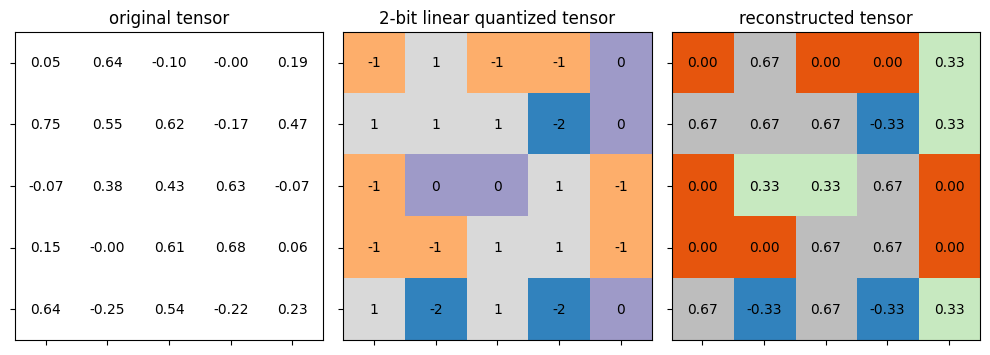

In [208]:
def linear_quantize(fp_tensor, bitwidth, scale, zero_point, dtype=torch.int8) -> torch.Tensor:
    """
    linear quantization for single fp_tensor
      from
        fp_tensor = (quantized_tensor - zero_point) * scale
      we have,
        quantized_tensor = int(round(fp_tensor / scale)) + zero_point
    :param tensor: [torch.(cuda.)FloatTensor] floating tensor to be quantized
    :param bitwidth: [int] quantization bit width
    :param scale: [torch.(cuda.)FloatTensor] scaling factor
    :param zero_point: [torch.(cuda.)IntTensor] the desired centroid of tensor values
    :return:
        [torch.(cuda.)FloatTensor] quantized tensor whose values are integers
    """
    assert(fp_tensor.dtype == torch.float)
    assert(isinstance(scale, float) or
           (scale.dtype == torch.float and scale.dim() == fp_tensor.dim()))
    assert(isinstance(zero_point, int) or
           (zero_point.dtype == dtype and zero_point.dim() == fp_tensor.dim()))

    # Step 1: scale the fp_tensor
    scaled_tensor = (fp_tensor)/scale
    # max(fp_tensor)-min(fp_tensor)/(1<<bitwidth-1)
    
    # Step 2: round the floating value to integer value
    rounded_tensor = torch.round(scaled_tensor)
    
    rounded_tensor = rounded_tensor.to(dtype)
    
    # Step 3: shift the rounded_tensor to make zero_point 0
    shifted_tensor = rounded_tensor+zero_point

    # Step 4: clamp the shifted_tensor to lie in bitwidth-bit range
    quantized_min, quantized_max = get_quantized_range(bitwidth)
    quantized_tensor = shifted_tensor.clamp_(quantized_min, quantized_max)
    return quantized_tensor
  
def plot_matrix(tensor, ax, title, vmin=0, vmax=1, cmap=ListedColormap(['white'])):
        ax.imshow(tensor.cpu().numpy(), vmin=vmin, vmax=vmax, cmap=cmap)
        ax.set_title(title)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        for i in range(tensor.shape[0]):
            for j in range(tensor.shape[1]):
                datum = tensor[i, j].item()
                if isinstance(datum, float):
                    text = ax.text(j, i, f'{datum:.2f}',
                                    ha="center", va="center", color="k")
                else:
                    text = ax.text(j, i, f'{datum}',
                                    ha="center", va="center", color="k")  
def get_quantization_scale_and_zero_point(fp_tensor, bitwidth):
    """
    get quantization scale for single tensor
    :param fp_tensor: [torch.(cuda.)Tensor] floating tensor to be quantized
    :param bitwidth: [int] quantization bit width
    :return:
        [float] scale
        [int] zero_point
    """
    quantized_min, quantized_max = get_quantized_range(bitwidth)
    fp_max = fp_tensor.max().item()
    fp_min = fp_tensor.min().item()
    
    scale = (fp_max-fp_min)/(quantized_max-quantized_min)
    # hint: one line of code for calculating zero_point
    zero_point = quantized_min-fp_min/scale

    # clip the zero_point to fall in [quantized_min, quantized_max]
    if zero_point < quantized_min:
        zero_point = quantized_min
    elif zero_point > quantized_max:
        zero_point = quantized_max
    else: # convert from float to int using round()
        zero_point = round(zero_point)
    return scale, int(zero_point)

def linear_quantize_feature(fp_tensor, bitwidth):
    """
    linear quantization for feature tensor
    :param fp_tensor: [torch.(cuda.)Tensor] floating feature to be quantized
    :param bitwidth: [int] quantization bit width
    :return:
        [torch.(cuda.)Tensor] quantized tensor
        [float] scale tensor
        [int] zero point
    """
    scale, zero_point = get_quantization_scale_and_zero_point(fp_tensor, bitwidth)
    quantized_tensor = linear_quantize(fp_tensor, bitwidth, scale, zero_point)
    return quantized_tensor, scale, zero_point
if __name__ == '__main__':
    bitwidth = 2
    test_tensor=torch.tensor([
            [ 0.0523,  0.6364, -0.0968, -0.0020,  0.1940],
            [ 0.7500,  0.5507,  0.6188, -0.1734,  0.4677],
            [-0.0669,  0.3836,  0.4297,  0.6267, -0.0695],
            [ 0.1536, -0.0038,  0.6075,  0.6817,  0.0601],
            [ 0.6446, -0.2500,  0.5376, -0.2226,  0.2333]])
    quantized_min, quantized_max = get_quantized_range(bitwidth)
    fig, axes = plt.subplots(1,3, figsize=(10, 32))
    real_min = test_tensor.min().item()
    real_max =  test_tensor.max().item()
    #   scale,zero_point = get_quantization_scale_and_zero_point(test_tensor, bitwidth)
    # #   scale = (real_max - real_min) / (quantized_max - quantized_min)
    # #   zero_point = int(np.round(quantized_min-real_min / scale))
    plot_matrix(test_tensor, axes[0], 'original tensor', vmin=real_min, vmax=real_max)
    #   _quantized_test_tensor = linear_quantize(
    #       test_tensor, bitwidth=bitwidth, scale=scale, zero_point=zero_point)
    _quantized_test_tensor, scale, zero_point = linear_quantize_feature(test_tensor, bitwidth)
    _reconstructed_test_tensor = scale * (_quantized_test_tensor.float() - zero_point)
    print('* Test linear_quantize()')
    print(f'    target bitwidth: {bitwidth} bits')
    print(f'        scale: {scale}')
    print(f'        zero point: {zero_point}')
    print('* Test passed.')
    plot_matrix(_quantized_test_tensor, axes[1], f'2-bit linear quantized tensor',
                vmin=quantized_min, vmax=quantized_max, cmap='tab20c')
    plot_matrix(_reconstructed_test_tensor, axes[2], f'reconstructed tensor',
                vmin=real_min, vmax=real_max, cmap='tab20c')
    fig.tight_layout()
    plt.show()
  

### 2.4.3 **特殊情况**：权重的量化
  我们首先看一下权重数据的分布

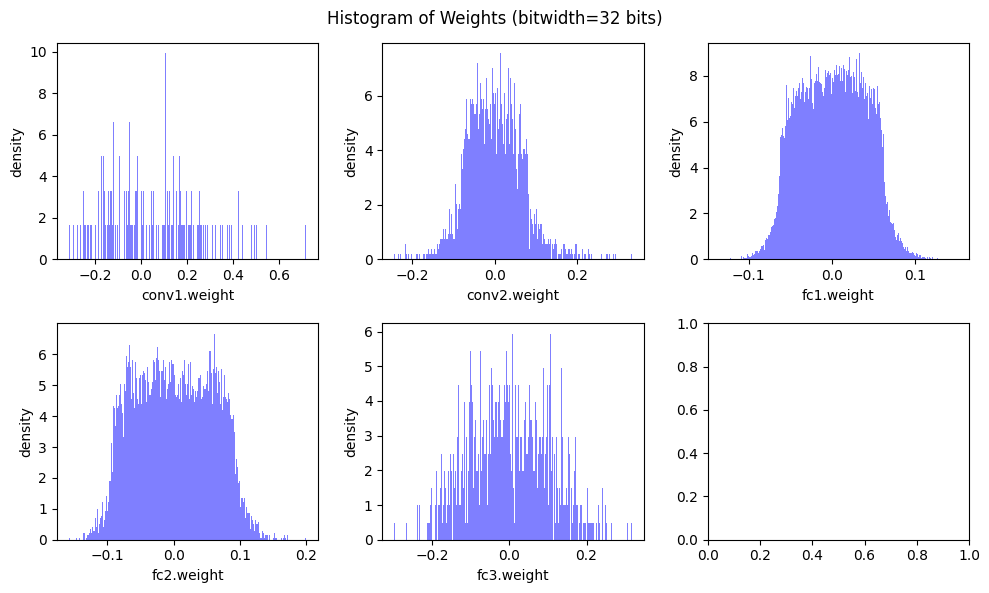

In [209]:
def plot_weight_distribution(model, bitwidth=32):
    # bins = (1 << bitwidth) if bitwidth <= 8 else 256
    if bitwidth <= 8:
        qmin, qmax = get_quantized_range(bitwidth)
        bins = np.arange(qmin, qmax + 2)
        align = 'left'
    else:
        bins = 256
        align = 'mid'
    fig, axes = plt.subplots(2,3, figsize=(10, 6))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            ax.hist(param.detach().view(-1).cpu(), bins=bins, density=True,
                    align=align, color = 'blue', alpha = 0.5,
                    edgecolor='black' if bitwidth <= 4 else None)
            if bitwidth <= 4:
                quantized_min, quantized_max = get_quantized_range(bitwidth)
                ax.set_xticks(np.arange(start=quantized_min, stop=quantized_max+1))
            ax.set_xlabel(name)
            ax.set_ylabel('density')
            plot_index += 1
    fig.suptitle(f'Histogram of Weights (bitwidth={bitwidth} bits)')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()
test_model = copy.deepcopy(model)
plot_weight_distribution(test_model)


如上面的直方图所示，权重值的分布大致对称于0（除了这种情况下的分类器）。因此，在量化权重时，通常我们将零点$Z=0$。

从$r = S(q-Z)$，我们有

$r_{\mathrm{max}} = S \cdot q_{\mathrm{max}}$

然后

$S = r_{\mathrm{max}} / q_{\mathrm{max}}$

我们直接使用权重值的最大幅值作为$r_{\mathrm{max}}$。

In [210]:

def get_quantization_scale_for_weight(weight, bitwidth):
    """
    get quantization scale for single tensor of weight
    :param weight: [torch.(cuda.)Tensor] floating weight to be quantized
    :param bitwidth: [integer] quantization bit width
    :return:
        [floating scalar] scale
    """
    # we just assume values in weight are symmetric
    # we also always make zero_point 0 for weight
    fp_max = max(weight.abs().max().item(), 5e-7)
    _, quantized_max = get_quantized_range(bitwidth)
    return fp_max / quantized_max




### 2.4.4 按通道线性量化

回顾一下，对于二维卷积，权重张量是一个四维张量，形状为（输出通道数，输入通道数，卷积核高度，卷积核宽度）。

大量实验表明，对于不同的输出通道使用不同的缩放因子 $S$ 和零点 $Z$ 将会表现更好。因此，我们需要独立确定每个输出通道的子张量的缩放因子 $S$ 和零点 $Z$。



In [211]:
def linear_quantize_weight_per_channel(tensor, bitwidth):
    """
    linear quantization for weight tensor
        using different scales and zero_points for different output channels
    :param tensor: [torch.(cuda.)Tensor] floating weight to be quantized
    :param bitwidth: [int] quantization bit width
    :return:
        [torch.(cuda.)Tensor] quantized tensor
        [torch.(cuda.)Tensor] scale tensor
        [int] zero point (which is always 0)
    """
    dim_output_channels = 0
    num_output_channels = tensor.shape[dim_output_channels]
    scale = torch.zeros(num_output_channels, device=tensor.device)
    for oc in range(num_output_channels):
        _subtensor = tensor.select(dim_output_channels, oc)
        _scale = get_quantization_scale_for_weight(_subtensor, bitwidth)
        scale[oc] = _scale
    scale_shape = [1] * tensor.dim()
    scale_shape[dim_output_channels] = -1
    
    scale = scale.view(scale_shape)# 举例子：3->3,1,1,1(后边的维度=tensor的维度)
    quantized_tensor = linear_quantize(tensor, bitwidth, scale, zero_point=0)
    return quantized_tensor, scale, 0

接下来我们看一下应用不同比特宽度的线性权重量化时，权重分布。

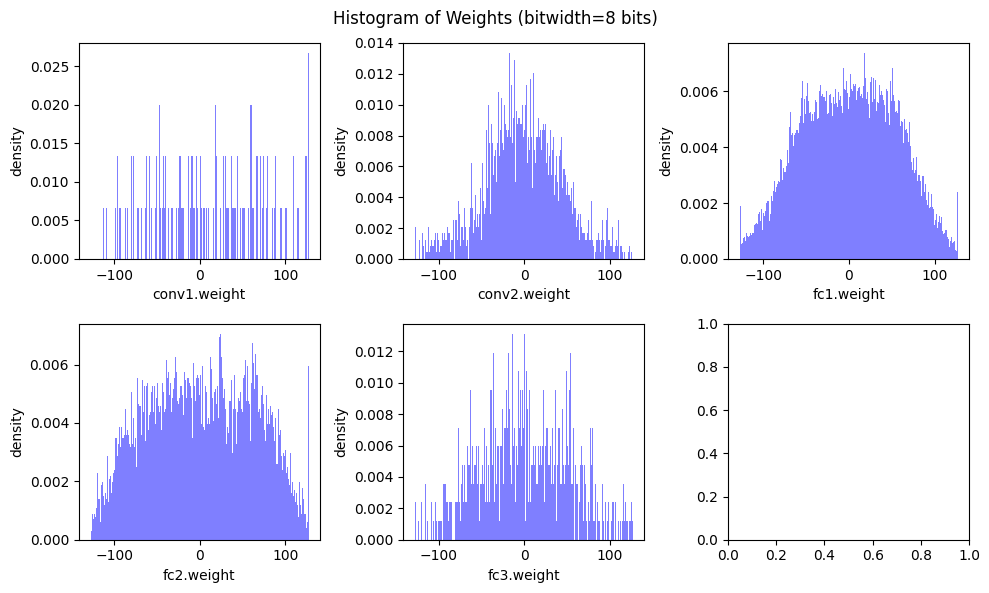

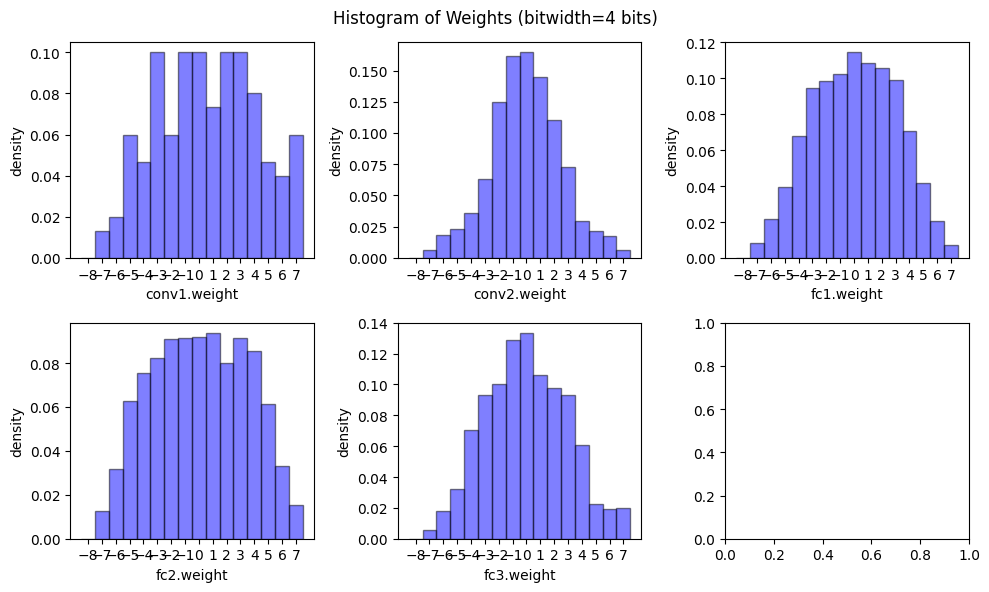

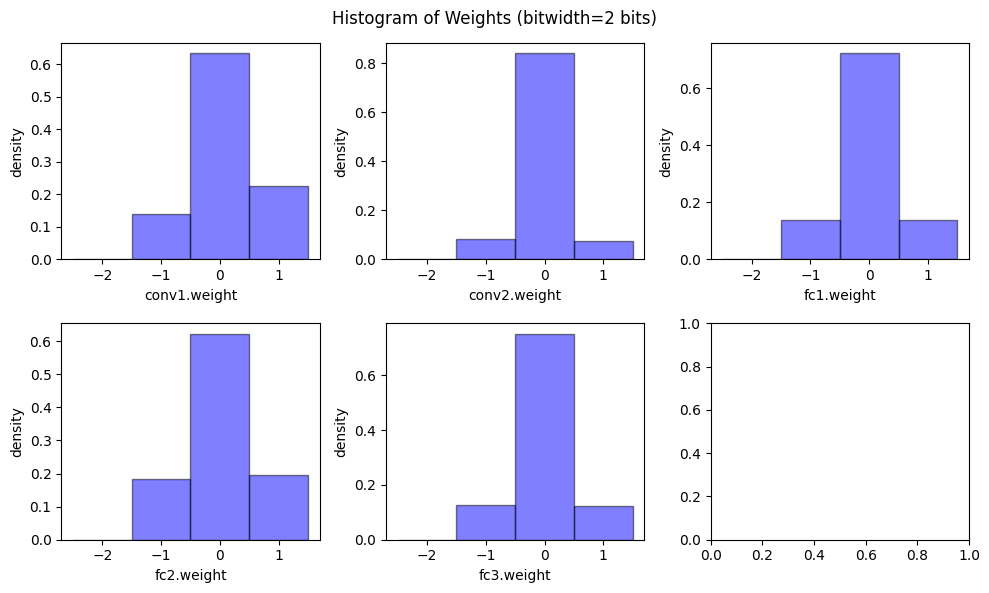

In [212]:
@torch.no_grad()
def model_linear_quantization():
    for bitwidth in [8, 4, 2]:
        for name, param in model.named_parameters():
            if param.dim() > 1:
                quantized_param, scale, zero_point = \
                    linear_quantize_weight_per_channel(param, bitwidth)
                param.copy_(quantized_param)
        plot_weight_distribution(model, bitwidth)

model_linear_quantization()

### 2.4.5  卷积和全连接层的线性量化
在量化之后，卷积和全连接层的推理也会发生变化。

回想一下 $r = S(q-Z)$，我们有

> $r_{\mathrm{input}} = S_{\mathrm{input}}(q_{\mathrm{input}}-Z_{\mathrm{input}})$
>
> $r_{\mathrm{weight}} = S_{\mathrm{weight}}(q_{\mathrm{weight}}-Z_{\mathrm{weight}})$
>
> $r_{\mathrm{bias}} = S_{\mathrm{bias}}(q_{\mathrm{bias}}-Z_{\mathrm{bias}})$

由于 $Z_{\mathrm{weight}}=0$，$r_{\mathrm{weight}} = S_{\mathrm{weight}}q_{\mathrm{weight}}$。

浮点卷积可以写成，

> $r_{\mathrm{output}} = \mathrm{CONV}[r_{\mathrm{input}}, r_{\mathrm{weight}}] + r_{\mathrm{bias}}\\
\;\;\;\;\;\;\;\;= \mathrm{CONV}[S_{\mathrm{input}}(q_{\mathrm{input}}-Z_{\mathrm{input}}), S_{\mathrm{weight}}q_{\mathrm{weight}}] + S_{\mathrm{bias}}(q_{\mathrm{bias}}-Z_{\mathrm{bias}})\\
\;\;\;\;\;\;\;\;= \mathrm{CONV}[q_{\mathrm{input}}-Z_{\mathrm{input}}, q_{\mathrm{weight}}]\cdot (S_{\mathrm{input}} \cdot S_{\mathrm{weight}}) + S_{\mathrm{bias}}(q_{\mathrm{bias}}-Z_{\mathrm{bias}})$

为了进一步简化计算，我们可以让

> $Z_{\mathrm{bias}} = 0$
>
> $S_{\mathrm{bias}} = S_{\mathrm{input}} \cdot S_{\mathrm{weight}}$

这样

> $r_{\mathrm{output}} = (\mathrm{CONV}[q_{\mathrm{input}}-Z_{\mathrm{input}}, q_{\mathrm{weight}}] + q_{\mathrm{bias}})\cdot (S_{\mathrm{input}} \cdot S_{\mathrm{weight}})$
> $\;\;\;\;\;\;\;\;= (\mathrm{CONV}[q_{\mathrm{input}}, q_{\mathrm{weight}}] - \mathrm{CONV}[Z_{\mathrm{input}}, q_{\mathrm{weight}}] + q_{\mathrm{bias}})\cdot (S_{\mathrm{input}}S_{\mathrm{weight}})$

由于
> $r_{\mathrm{output}} = S_{\mathrm{output}}(q_{\mathrm{output}}-Z_{\mathrm{output}})$

我们有
> $S_{\mathrm{output}}(q_{\mathrm{output}}-Z_{\mathrm{output}}) = (\mathrm{CONV}[q_{\mathrm{input}}, q_{\mathrm{weight}}] - \mathrm{CONV}[Z_{\mathrm{input}}, q_{\mathrm{weight}}] + q_{\mathrm{bias}})\cdot (S_{\mathrm{input}} S_{\mathrm{weight}})$

因此
> $q_{\mathrm{output}} = (\mathrm{CONV}[q_{\mathrm{input}}, q_{\mathrm{weight}}] - \mathrm{CONV}[Z_{\mathrm{input}}, q_{\mathrm{weight}}] + q_{\mathrm{bias}})\cdot (S_{\mathrm{input}}S_{\mathrm{weight}} / S_{\mathrm{output}}) + Z_{\mathrm{output}}$

由于 $Z_{\mathrm{input}}$，$q_{\mathrm{weight}}$，$q_{\mathrm{bias}}$ 在推理之前就确定了，让

> $Q_{\mathrm{bias}} = q_{\mathrm{bias}} - \mathrm{CONV}[Z_{\mathrm{input}}, q_{\mathrm{weight}}]$

我们有

> $q_{\mathrm{output}} = (\mathrm{CONV}[q_{\mathrm{input}}, q_{\mathrm{weight}}] + Q_{\mathrm{bias}}) \cdot (S_{\mathrm{input}}S_{\mathrm{weight}} / S_{\mathrm{output}}) + Z_{\mathrm{output}}$

类似地，对于全连接层，

> $q_{\mathrm{output}} = (\mathrm{Linear}[q_{\mathrm{input}}, q_{\mathrm{weight}}] + Q_{\mathrm{bias}})\cdot (S_{\mathrm{input}} \cdot S_{\mathrm{weight}} / S_{\mathrm{output}}) + Z_{\mathrm{output}}$

其中

> $Q_{\mathrm{bias}} = q_{\mathrm{bias}} - \mathrm{Linear}[Z_{\mathrm{input}}, q_{\mathrm{weight}}]$

In [213]:
def linear_quantize_bias_per_output_channel(bias, weight_scale, input_scale):
    """
    linear quantization for single bias tensor
        quantized_bias = fp_bias / bias_scale
    :param bias: [torch.FloatTensor] bias weight to be quantized
    :param weight_scale: [float or torch.FloatTensor] weight scale tensor
    :param input_scale: [float] input scale
    :return:
        [torch.IntTensor] quantized bias tensor
    """
    assert(bias.dim() == 1)
    assert(bias.dtype == torch.float)
    assert(isinstance(input_scale, float))
    if isinstance(weight_scale, torch.Tensor):
        assert(weight_scale.dtype == torch.float)
        weight_scale = weight_scale.view(-1)
        assert(bias.numel() == weight_scale.numel())

    bias_scale = weight_scale*input_scale

    quantized_bias = linear_quantize(bias, 32, bias_scale,
                                     zero_point=0, dtype=torch.int32)
    return quantized_bias, bias_scale, 0

### 2.4.6 全连接层量化

In [214]:
def shift_quantized_linear_bias(quantized_bias, quantized_weight, input_zero_point):
    """
    shift quantized bias to incorporate input_zero_point for nn.Linear
        shifted_quantized_bias = quantized_bias - Linear(input_zero_point, quantized_weight)
    :param quantized_bias: [torch.IntTensor] quantized bias (torch.int32)
    :param quantized_weight: [torch.CharTensor] quantized weight (torch.int8)
    :param input_zero_point: [int] input zero point
    :return:
        [torch.IntTensor] shifted quantized bias tensor
    """
    assert(quantized_bias.dtype == torch.int32)
    assert(isinstance(input_zero_point, int))
    # print(quantized_weight.sum(1).to(torch.int32) * input_zero_point)
    return quantized_bias - quantized_weight.sum(1).to(torch.int32) * input_zero_point

* Test quantized_fc()
    target bitwidth: 2 bits
      batch size: 64
      input channels: 8
      output channels: 8
      input scale: 0.281600009649992
      input zero point: -2
      weight scale: tensor([[0.2498],
        [0.4383],
        [0.4250],
        [0.4243],
        [0.4533],
        [0.3687],
        [0.3767],
        [0.4335]])
      weight zero point: 0
      bias scale: tensor([0.0703, 0.1234, 0.1197, 0.1195, 0.1277, 0.1038, 0.1061, 0.1221])
      bias zero point: 0
      output scale: 0.4681522846221924
      output zero point: 0
* Test passed.


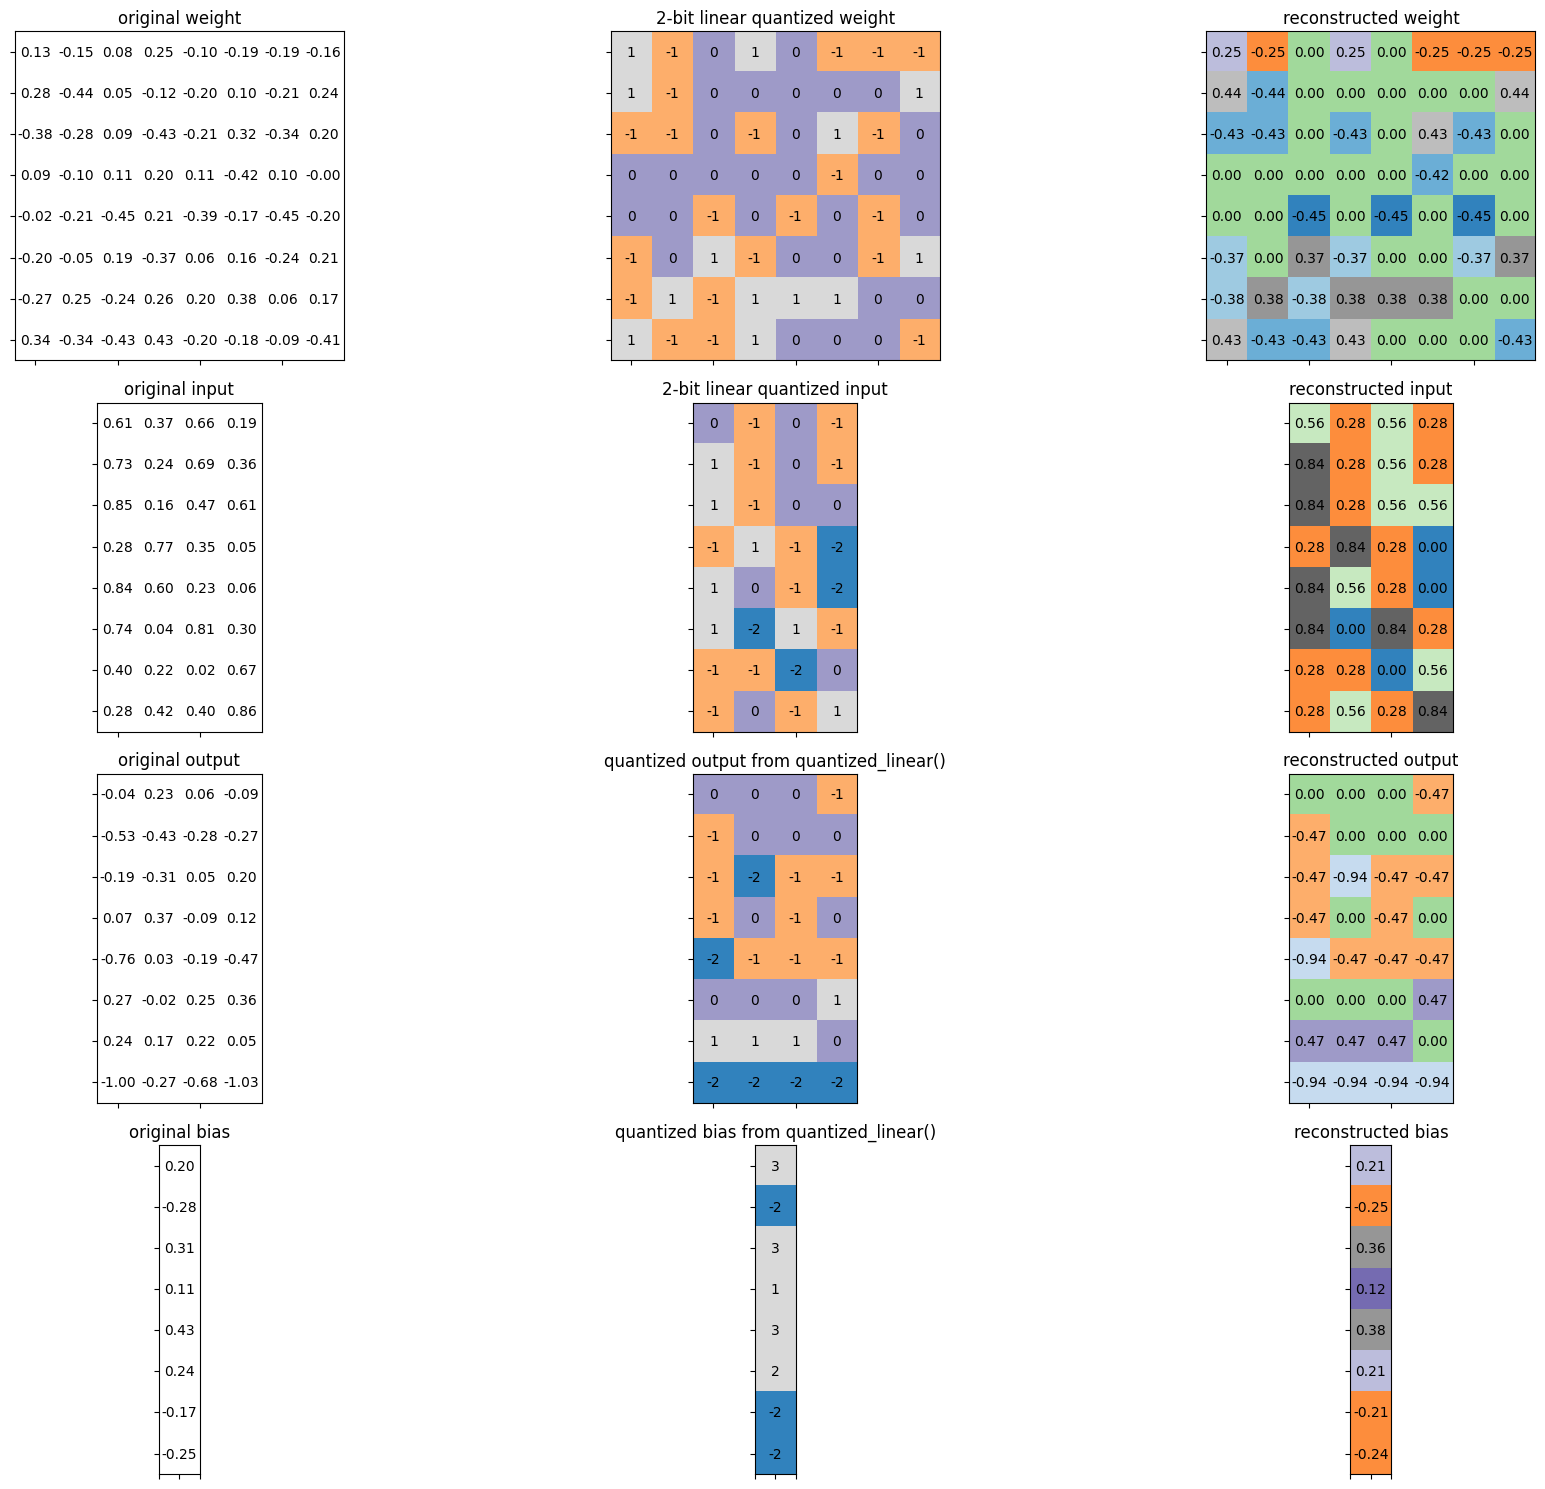

In [215]:
def quantized_linear(input, weight, bias, feature_bitwidth, weight_bitwidth,
                     input_zero_point, output_zero_point,
                     input_scale, weight_scale, output_scale):
    """
    quantized fully-connected layer
    :param input: [torch.CharTensor] quantized input (torch.int8)
    :param weight: [torch.CharTensor] quantized weight (torch.int8)
    :param bias: [torch.IntTensor] shifted quantized bias or None (torch.int32)
    :param feature_bitwidth: [int] quantization bit width of input and output
    :param weight_bitwidth: [int] quantization bit width of weight
    :param input_zero_point: [int] input zero point
    :param output_zero_point: [int] output zero point
    :param input_scale: [float] input feature scale
    :param weight_scale: [torch.FloatTensor] weight per-channel scale
    :param output_scale: [float] output feature scale
    :return:
        [torch.CharIntTensor] quantized output feature (torch.int8)
    """
    assert(input.dtype == torch.int8)
    assert(weight.dtype == input.dtype)
    assert(bias is None or bias.dtype == torch.int32)
    assert(isinstance(input_zero_point, int))
    assert(isinstance(output_zero_point, int))
    assert(isinstance(input_scale, float))
    assert(isinstance(output_scale, float))
    assert(weight_scale.dtype == torch.float)

    # Step 1: integer-based fully-connected (8-bit multiplication with 32-bit accumulation)
    if 'cpu' in input.device.type:
        # use 32-b MAC for simplicity
        output = torch.nn.functional.linear(input.to(torch.int32), weight.to(torch.int32), bias)
    else:
        # current version pytorch does not yet support integer-based linear() on GPUs
        output = torch.nn.functional.linear(input.float(), weight.float(), bias.float())
    # Step 2: scale the output
    #         hint: 1. scales are floating numbers, we need to convert output to float as well
    #               2. the shape of weight scale is [oc, 1, 1, 1] while the shape of output is [batch_size, oc]
    weight_scale_expanded = weight_scale.reshape(1,-1).expand_as(output)
    # print((output+bias).float())
    # print(weight_scale_expanded)
    # print(input_scale * weight_scale_expanded / (output_scale))
    
    output = (output+bias).float() * (input_scale * weight_scale_expanded / (output_scale))

    
    # Step 3: shift output by output_zero_point
    output += output_zero_point
    # Make sure all value lies in the bitwidth-bit range
    output = output.round().clamp(*get_quantized_range(feature_bitwidth)).to(torch.int8)
    return output

def plot_matrix(tensor, ax, title, vmin=0, vmax=1, cmap=ListedColormap(['white'])):
    ax.imshow(tensor.cpu().numpy(), vmin=vmin, vmax=vmax, cmap=cmap)
    ax.set_title(title)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    for i in range(tensor.shape[0]):
        for j in range(tensor.shape[1]):
            datum = tensor[i, j].item()
            if isinstance(datum, float):
                text = ax.text(j, i, f'{datum:.2f}',
                                ha="center", va="center", color="k")
            else:
                text = ax.text(j, i, f'{datum}',
                                ha="center", va="center", color="k")
def quantized_linear_output(weight, bias, input,output,bitwidth):
    
    quantized_weight, weight_scale, weight_zero_point = linear_quantize_weight_per_channel(weight, bitwidth)#对称量化

    quantized_input, input_scale, input_zero_point = linear_quantize_feature(input, bitwidth) #正常量化

    quantized_bias, bias_scale, bias_zero_point = linear_quantize_bias_per_output_channel(bias, weight_scale, input_scale)#bias量化
        
    shifted_quantized_bias = shift_quantized_linear_bias(quantized_bias, quantized_weight, input_zero_point)#bias量化shift

    _, output_scale, output_zero_point = linear_quantize_feature(output, bitwidth)#output量化

    calc_quantized_output = quantized_linear(
        quantized_input, quantized_weight, shifted_quantized_bias,
        bitwidth, bitwidth,
        input_zero_point, output_zero_point,
        input_scale, weight_scale, output_scale) 
    
    return   calc_quantized_output,output_scale,output_zero_point,\
        quantized_weight, weight_scale,weight_zero_point,\
        quantized_input, input_scale, input_zero_point, \
        quantized_bias,bias_scale,bias_zero_point
        
if __name__ == '__main__':
    input=torch.tensor([
        [0.6118, 0.7288, 0.8511, 0.2849, 0.8427, 0.7435, 0.4014, 0.2794],
        [0.3676, 0.2426, 0.1612, 0.7684, 0.6038, 0.0400, 0.2240, 0.4237],
        [0.6565, 0.6878, 0.4670, 0.3470, 0.2281, 0.8074, 0.0178, 0.3999],
        [0.1863, 0.3567, 0.6104, 0.0497, 0.0577, 0.2990, 0.6687, 0.8626]])
    weight=torch.tensor([
        [ 1.2626e-01, -1.4752e-01,  8.1910e-02,  2.4982e-01, -1.0495e-01,
         -1.9227e-01, -1.8550e-01, -1.5700e-01],
        [ 2.7624e-01, -4.3835e-01,  5.1010e-02, -1.2020e-01, -2.0344e-01,
          1.0202e-01, -2.0799e-01,  2.4112e-01],
        [-3.8216e-01, -2.8047e-01,  8.5238e-02, -4.2504e-01, -2.0952e-01,
          3.2018e-01, -3.3619e-01,  2.0219e-01],
        [ 8.9233e-02, -1.0124e-01,  1.1467e-01,  2.0091e-01,  1.1438e-01,
         -4.2427e-01,  1.0178e-01, -3.0941e-04],
        [-1.8837e-02, -2.1256e-01, -4.5285e-01,  2.0949e-01, -3.8684e-01,
         -1.7100e-01, -4.5331e-01, -2.0433e-01],
        [-2.0038e-01, -5.3757e-02,  1.8997e-01, -3.6866e-01,  5.5484e-02,
          1.5643e-01, -2.3538e-01,  2.1103e-01],
        [-2.6875e-01,  2.4984e-01, -2.3514e-01,  2.5527e-01,  2.0322e-01,
          3.7675e-01,  6.1563e-02,  1.7201e-01],
        [ 3.3541e-01, -3.3555e-01, -4.3349e-01,  4.3043e-01, -2.0498e-01,
         -1.8366e-01, -9.1553e-02, -4.1168e-01]])
    bias=torch.tensor([ 0.1954, -0.2756,  0.3113,  0.1149,  0.4274,  0.2429, -0.1721, -0.2502])
    bitwidth=2
    in_channels=weight.shape[1]
    out_channels=weight.shape[0]
    output = torch.nn.functional.linear(input, weight, bias)
    # quantized_min, quantized_max = get_quantized_range(bitwidth)
    # print(output)
    # print(output.max())
    # print(output.min())
    # scale = (output.max() - output.min())/(quantized_max - quantized_min)
    # print(scale)
    # zero_point = quantized_min-output.min()/scale
    # print(zero_point )
    calc_quantized_output,output_scale,output_zero_point,\
        quantized_weight, weight_scale,weight_zero_point,\
        quantized_input, input_scale, input_zero_point, \
        quantized_bias,bias_scale,bias_zero_point = quantized_linear_output(weight, bias, input,output,bitwidth)
        
    reconstructed_weight = weight_scale * (quantized_weight.float() - weight_zero_point)
    reconstructed_input = input_scale * (quantized_input.float() - input_zero_point)
    reconstructed_bias = bias_scale * (quantized_bias.float() - bias_zero_point)
    reconstructed_calc_output = output_scale * (calc_quantized_output.float() - output_zero_point)

    fig, axes = plt.subplots(4,3, figsize=(20, 15))
    
    plot_matrix(weight, axes[0, 0], 'original weight', vmin=-0.5, vmax=0.5)
    plot_matrix(input.t(), axes[1, 0], 'original input', vmin=0, vmax=1)
    plot_matrix(output.t(), axes[2, 0], 'original output', vmin=-1.5, vmax=1.5)
    plot_matrix(bias.reshape(1,-1).t(), axes[3,0], 'original bias')
    
    plot_matrix(quantized_weight, axes[0, 1], f'{bitwidth}-bit linear quantized weight',
                vmin=quantized_min, vmax=quantized_max, cmap='tab20c')
    plot_matrix(quantized_input.t(), axes[1, 1], f'{bitwidth}-bit linear quantized input',
                vmin=quantized_min, vmax=quantized_max, cmap='tab20c')
    plot_matrix(calc_quantized_output.t(), axes[2, 1], f'quantized output from quantized_linear()',
                vmin=quantized_min, vmax=quantized_max, cmap='tab20c')
    plot_matrix(quantized_bias.reshape(1,-1).t(), axes[3,1], f'quantized bias from quantized_linear()',
                vmin=quantized_min, vmax=quantized_max, cmap='tab20c')
    
    
    plot_matrix(reconstructed_weight, axes[0, 2], f'reconstructed weight',
                vmin=-0.5, vmax=0.5, cmap='tab20c')
    plot_matrix(reconstructed_input.t(), axes[1, 2], f'reconstructed input',
                vmin=0, vmax=1, cmap='tab20c')
    plot_matrix(reconstructed_calc_output.t(), axes[2, 2], f'reconstructed output',
                vmin=-1.5, vmax=1.5, cmap='tab20c')
    plot_matrix(reconstructed_bias.reshape(1,-1).t(), axes[3,2], f'reconstructed bias',
                vmin=-0.5, vmax=0.5, cmap='tab20c')

    print('* Test quantized_fc()')
    print(f'    target bitwidth: {bitwidth} bits')
    print(f'      batch size: {batch_size}')
    print(f'      input channels: {in_channels}')
    print(f'      output channels: {out_channels}')
    print(f'      input scale: {input_scale}')
    print(f'      input zero point: {input_zero_point}')
    print(f'      weight scale: {weight_scale}')
    print(f'      weight zero point: {weight_zero_point}')
    print(f'      bias scale: {bias_scale}')
    print(f'      bias zero point: {bias_zero_point}')
    print(f'      output scale: {output_scale}')
    print(f'      output zero point: {output_zero_point}')
    print('* Test passed.')
    fig.tight_layout()
    plt.show()
    
    

### 2.4.7 卷积层量化

> $Q_{\mathrm{bias}} = q_{\mathrm{bias}} - \mathrm{CONV}[Z_{\mathrm{input}}, q_{\mathrm{weight}}]$.
> 
> $q_{\mathrm{output}} = (\mathrm{CONV}[q_{\mathrm{input}}, q_{\mathrm{weight}}] + Q_{\mathrm{bias}}) \cdot (S_{\mathrm{input}}S_{\mathrm{weight}} / S_{\mathrm{output}}) + Z_{\mathrm{output}}$

In [216]:
def shift_quantized_conv2d_bias(quantized_bias, quantized_weight, input_zero_point):
    """
    shift quantized bias to incorporate input_zero_point for nn.Conv2d
        shifted_quantized_bias = quantized_bias - Conv(input_zero_point, quantized_weight)
    :param quantized_bias: [torch.IntTensor] quantized bias (torch.int32)
    :param quantized_weight: [torch.CharTensor] quantized weight (torch.int8)
    :param input_zero_point: [int] input zero point
    :return:
        [torch.IntTensor] shifted quantized bias tensor
    """
    assert(quantized_bias.dtype == torch.int32)
    assert(isinstance(input_zero_point, int))
    return quantized_bias - quantized_weight.sum((1,2,3)).to(torch.int32) * input_zero_point

In [217]:
def quantized_conv2d(input, weight, bias, feature_bitwidth, weight_bitwidth,
                     input_zero_point, output_zero_point,
                     input_scale, weight_scale, output_scale,
                     stride, padding, dilation, groups):
    """
    quantized 2d convolution
    :param input: [torch.CharTensor] quantized input (torch.int8)
    :param weight: [torch.CharTensor] quantized weight (torch.int8)
    :param bias: [torch.IntTensor] shifted quantized bias or None (torch.int32)
    :param feature_bitwidth: [int] quantization bit width of input and output
    :param weight_bitwidth: [int] quantization bit width of weight
    :param input_zero_point: [int] input zero point
    :param output_zero_point: [int] output zero point
    :param input_scale: [float] input feature scale
    :param weight_scale: [torch.FloatTensor] weight per-channel scale
    :param output_scale: [float] output feature scale
    :return:
        [torch.(cuda.)CharTensor] quantized output feature
    """
    assert(len(padding) == 4)
    assert(input.dtype == torch.int8)
    assert(weight.dtype == input.dtype)
    assert(bias is None or bias.dtype == torch.int32)
    assert(isinstance(input_zero_point, int))
    assert(isinstance(output_zero_point, int))
    assert(isinstance(input_scale, float))
    assert(isinstance(output_scale, float))
    assert(weight_scale.dtype == torch.float)

    # Step 1: calculate integer-based 2d convolution (8-bit multiplication with 32-bit accumulation)
    input = torch.nn.functional.pad(input, padding, 'constant', input_zero_point)
    if 'cpu' in input.device.type:
        # use 32-b MAC for simplicity
        output = torch.nn.functional.conv2d(input.to(torch.int32), weight.to(torch.int32), None, stride, 0, dilation, groups)
    else:
        # current version pytorch does not yet support integer-based conv2d() on GPUs
        output = torch.nn.functional.conv2d(input.float(), weight.float(), None, stride, 0, dilation, groups)
        output = output.round().to(torch.int32)
    if bias is not None:
        output = output + bias.view(1, -1, 1, 1)

    # Step 2: scale the output
    #         hint: 1. scales are floating numbers, we need to convert output to float as well
    #               2. the shape of weight scale is [oc, 1, 1, 1] while the shape of output is [batch_size, oc, height, width]
    # print(output.shape)
    # print(((input_scale*weight_scale)/output_scale).reshape(-1).shape)
    output = output*((input_scale*weight_scale)/output_scale).reshape(1,-1,1,1).expand_as(output)

    # Step 3: shift output by output_zero_point
  
    output += output_zero_point
    # Make sure all value lies in the bitwidth-bit range
    output = output.round().clamp(*get_quantized_range(feature_bitwidth)).to(torch.int8)
    return output

## 2.5 训练后量化

最后，我们将所有步骤汇总起来，对模型进行后训练的 `int8` 量化。我们将逐个将模型中的卷积层和线性层转换为量化版本。
步骤如下：

-  我们将使用一些样本数据运行模型，以获取每个特征图的范围，这样我们就可以得到特征图的范围，并计算它们对应的缩放因子和零点。
-  在 `_record_range` 函数中，实际上我们只记录了输入和输出张量的值，并将它们存储在全局字典 `input_activation` 和 `output_activation` 中，以模块名称作为键。这样做的目的是为了在模型的每个模块中记录输入和输出的张量数据，以便在需要时进行分析或后续处理。
-  最后开始量化，在 QuantizedMaxPool2d 类中，我们只需要调用父类的 forward 方法，并在其基础上进行后续处理，例如将池化结果转换为整数类型。因此，QuantizedMaxPool2d 类的 forward 方法本身并没有实现最大池化操作，而是委托给了父类的 forward 方法来完成最大池化操作。super()

-  验证量化后模型的精度


In [218]:
# add hook to record the min max value of the activation
input_activation = {}
output_activation = {}

def add_range_recoder_hook(model):
    import functools
    def _record_range(self, x, y, module_name):
        x = x[0]
        input_activation[module_name] = x.detach()
        output_activation[module_name] = y.detach()

    all_hooks = []
    for name, m in model.named_modules():
        if isinstance(m, (nn.Conv2d, nn.Linear, nn.ReLU)):
            all_hooks.append(m.register_forward_hook(
                functools.partial(_record_range, module_name=name)))
    return all_hooks
test_model = copy.deepcopy(model)
hooks = add_range_recoder_hook(test_model)
sample_data = iter(train_loader).__next__()[0]
test_model(sample_data)

# remove hooks
for h in hooks:
    h.remove()


In [235]:
class QuantizedConv2d(nn.Module):
    def __init__(self, weight, bias,
                 input_zero_point, output_zero_point,
                 input_scale, weight_scale, output_scale,
                 stride, padding, dilation, groups,
                 feature_bitwidth=8, weight_bitwidth=8):
        super().__init__()
        # current version Pytorch does not support IntTensor as nn.Parameter
        self.register_buffer('weight', weight)
        self.register_buffer('bias', bias)

        self.input_zero_point = input_zero_point
        self.output_zero_point = output_zero_point

        self.input_scale = input_scale
        self.register_buffer('weight_scale', weight_scale)
        self.output_scale = output_scale

        self.stride = stride
        self.padding = (padding[1], padding[1], padding[0], padding[0])
        self.dilation = dilation
        self.groups = groups

        self.feature_bitwidth = feature_bitwidth
        self.weight_bitwidth = weight_bitwidth


    def forward(self, x):
        # print(x.shape)
        # print(self.weight.shape)
        
        return quantized_conv2d(
            x, self.weight, self.bias,
            self.feature_bitwidth, self.weight_bitwidth,
            self.input_zero_point, self.output_zero_point,
            self.input_scale, self.weight_scale, self.output_scale,
            self.stride, self.padding, self.dilation, self.groups
            )

class QuantizedLinear(nn.Module):
    def __init__(self, weight, bias,
                 input_zero_point, output_zero_point,
                 input_scale, weight_scale, output_scale,
                 feature_bitwidth=8, weight_bitwidth=8):
        super().__init__()
        # current version Pytorch does not support IntTensor as nn.Parameter
        self.register_buffer('weight', weight)
        self.register_buffer('bias', bias)

        self.input_zero_point = input_zero_point
        self.output_zero_point = output_zero_point

        self.input_scale = input_scale
        self.register_buffer('weight_scale', weight_scale)
        self.output_scale = output_scale

        self.feature_bitwidth = feature_bitwidth
        self.weight_bitwidth = weight_bitwidth

    def forward(self, x):
        # print(x.shape)
        # print(self.weight.shape)
        return quantized_linear(
            x, self.weight, self.bias,
            self.feature_bitwidth, self.weight_bitwidth,
            self.input_zero_point, self.output_zero_point,
            self.input_scale, self.weight_scale, self.output_scale
            )

class QuantizedMaxPool2d(nn.MaxPool2d):
    def forward(self, x):
        # current version PyTorch does not support integer-based MaxPool
        return super().forward(x.float()).to(torch.int8)
class Reshape(nn.Module):
    def forward(self, x):
        # current version PyTorch does not support integer-based MaxPool
        return x.view(x.shape[0], -1)
class QuantizedAvgPool2d(nn.AvgPool2d):
    def forward(self, x):
        # current version PyTorch does not support integer-based AvgPool
        return super().forward(x.float()).to(torch.int8)

# we use int8 quantization, which is quite popular
feature_bitwidth = weight_bitwidth = 8
quantized_model = copy.deepcopy(model)
quantized_backbone = []
model_list = []
model_name = []
for name, layer in model.named_children():
    # print( name + ':', layer)

    model_list.append(layer)
    model_name.append(name)
    # print('finish')
ptr = 0
# print(model_list)
for name, layer in model.named_children():
    
    print(name, layer)
    print(ptr)
    if isinstance(layer, nn.Conv2d) :
        # print('conv')
        if isinstance(layer, nn.Conv2d) and isinstance(model_list[ptr+1], nn.ReLU):
            #print(ptr)
            input_scale, input_zero_point = get_quantization_scale_and_zero_point(
                    input_activation[name], feature_bitwidth)

            output_scale, output_zero_point = get_quantization_scale_and_zero_point(
                    output_activation[model_name[ptr+1]], feature_bitwidth)

            quantized_weight, weight_scale, weight_zero_point = linear_quantize_weight_per_channel(layer.weight.data, weight_bitwidth)
                
            quantized_bias, bias_scale, bias_zero_point = linear_quantize_bias_per_output_channel(
                    layer.bias.data, weight_scale, input_scale)
            shifted_quantized_bias = shift_quantized_conv2d_bias(quantized_bias, quantized_weight,
                                            input_zero_point)

            quantized_conv = QuantizedConv2d(
                quantized_weight, shifted_quantized_bias,
                input_zero_point, output_zero_point,
                input_scale, weight_scale, output_scale,
                layer.stride, layer.padding, layer.dilation, layer.groups,
                feature_bitwidth=feature_bitwidth, weight_bitwidth=weight_bitwidth
            )
            # print(quantized_conv)
            quantized_backbone.append(quantized_conv)
            ptr += 1
        else:
            #print(ptr)
            input_scale, input_zero_point = get_quantization_scale_and_zero_point(
                    input_activation[name], feature_bitwidth)

            output_scale, output_zero_point = get_quantization_scale_and_zero_point(
                    output_activation[model_name[ptr]], feature_bitwidth)

            quantized_weight, weight_scale, weight_zero_point = linear_quantize_weight_per_channel(layer.weight.data, weight_bitwidth)
                
            quantized_bias, bias_scale, bias_zero_point = linear_quantize_bias_per_output_channel(
                    layer.bias.data, weight_scale, input_scale)
            shifted_quantized_bias = shift_quantized_conv2d_bias(quantized_bias, quantized_weight,
                                            input_zero_point)

            quantized_conv = QuantizedConv2d(
                quantized_weight, shifted_quantized_bias,
                input_zero_point, output_zero_point,
                input_scale, weight_scale, output_scale,
                layer.stride, layer.padding, layer.dilation, layer.groups,
                feature_bitwidth=feature_bitwidth, weight_bitwidth=weight_bitwidth
            )
            # print(quantized_conv)
            quantized_backbone.append(quantized_conv)
            ptr += 1
    elif isinstance(layer, nn.MaxPool2d):
        if isinstance(layer, nn.MaxPool2d) and isinstance(model_list[ptr+1], nn.Linear):
            # print(888888)
            #print(ptr)
            quantized_backbone.append(QuantizedAvgPool2d(
                kernel_size=layer.kernel_size,
                stride=layer.stride
                ))
            quantized_backbone.append(Reshape()
                )
            ptr += 1

        else:
            #print(ptr)
            
            quantized_backbone.append(QuantizedAvgPool2d(
                kernel_size=layer.kernel_size,
                stride=layer.stride
                ))
            ptr += 1
    elif isinstance(layer, nn.Linear) :
  
        if isinstance(layer, nn.Linear) and  (ptr< len(model_list)-1)  :
            if isinstance(model_list[ptr+1], nn.ReLU):
                input_scale, input_zero_point = get_quantization_scale_and_zero_point(
                        input_activation[name], feature_bitwidth)

                output_scale, output_zero_point =  get_quantization_scale_and_zero_point(
                        output_activation[model_name[ptr+1]], feature_bitwidth)

                quantized_weight, weight_scale, weight_zero_point =  linear_quantize_weight_per_channel(layer.weight.data, weight_bitwidth)
                quantized_bias, bias_scale, bias_zero_point = linear_quantize_bias_per_output_channel(
                        layer.bias.data, weight_scale, input_scale)
                shifted_quantized_bias = shift_quantized_linear_bias(quantized_bias, quantized_weight,
                                                input_zero_point)

                quantized_lin = QuantizedLinear(
                    quantized_weight, shifted_quantized_bias,
                    input_zero_point, output_zero_point,
                    input_scale, weight_scale, output_scale,
                    feature_bitwidth=feature_bitwidth, weight_bitwidth=weight_bitwidth
                )
                quantized_backbone.append(quantized_lin)
                ptr += 1
            else:
                input_scale, input_zero_point = get_quantization_scale_and_zero_point(
                input_activation[name], feature_bitwidth)

                output_scale, output_zero_point =  get_quantization_scale_and_zero_point(
                        output_activation[name], feature_bitwidth)

                quantized_weight, weight_scale, weight_zero_point =  linear_quantize_weight_per_channel(layer.weight.data, weight_bitwidth)
                quantized_bias, bias_scale, bias_zero_point = linear_quantize_bias_per_output_channel(
                        layer.bias.data, weight_scale, input_scale)
                shifted_quantized_bias = shift_quantized_linear_bias(quantized_bias, quantized_weight,
                                                input_zero_point)

                quantized_lin = QuantizedLinear(
                    quantized_weight, shifted_quantized_bias,
                    input_zero_point, output_zero_point,
                    input_scale, weight_scale, output_scale,
                    feature_bitwidth=feature_bitwidth, weight_bitwidth=weight_bitwidth
                )
                quantized_backbone.append(quantized_lin)
                ptr += 1  
        else:
            input_scale, input_zero_point = get_quantization_scale_and_zero_point(
            input_activation[name], feature_bitwidth)

            output_scale, output_zero_point =  get_quantization_scale_and_zero_point(
                    output_activation[name], feature_bitwidth)

            quantized_weight, weight_scale, weight_zero_point =  linear_quantize_weight_per_channel(layer.weight.data, weight_bitwidth)
            quantized_bias, bias_scale, bias_zero_point = linear_quantize_bias_per_output_channel(
                    layer.bias.data, weight_scale, input_scale)
            shifted_quantized_bias = shift_quantized_linear_bias(quantized_bias, quantized_weight,
                                            input_zero_point)

            quantized_lin = QuantizedLinear(
                quantized_weight, shifted_quantized_bias,
                input_zero_point, output_zero_point,
                input_scale, weight_scale, output_scale,
                feature_bitwidth=feature_bitwidth, weight_bitwidth=weight_bitwidth
            )
            quantized_backbone.append(quantized_lin)
            ptr += 1  
    
    elif isinstance(layer, nn.ReLU):
        ptr += 1
    else:
        raise NotImplementedError(type(layer))  # should not happen
    
quantized_model = nn.Sequential(*quantized_backbone)

print(quantized_model)
print(model)

conv1 Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
0
relu1 ReLU()
1
maxpool1 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
2
conv2 Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
3
relu2 ReLU()
4
maxpool2 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
5
fc1 Linear(in_features=256, out_features=120, bias=True)
6
relu3 ReLU()
7
fc2 Linear(in_features=120, out_features=84, bias=True)
8
relu4 ReLU()
9
fc3 Linear(in_features=84, out_features=10, bias=True)
10
Sequential(
  (0): QuantizedConv2d()
  (1): QuantizedAvgPool2d(kernel_size=2, stride=2, padding=0)
  (2): QuantizedConv2d()
  (3): QuantizedAvgPool2d(kernel_size=2, stride=2, padding=0)
  (4): Reshape()
  (5): QuantizedLinear()
  (6): QuantizedLinear()
  (7): QuantizedLinear()
)
LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, ke

In [237]:
def extra_preprocess(x):
    # hint: you need to convert the original fp32 input of range (0, 1)
    #  into int8 format of range (-128, 127)
    # print(x.shape)
    return x.clamp(-128, 127).to(torch.int8)

int8_model_accuracy = evaluate(quantized_model, test_loader,
                               extra_preprocess=[extra_preprocess])
print(f"int8 model has accuracy={int8_model_accuracy:.2f}%")

int8 model has accuracy=10.10%
